In [1]:
from chyk import *
handcalcs.set_option("param_columns", 2)
from math import degrees as r2d
from math import radians as d2r
rho = 1.21  # $\frac{kg}{m^3}$, air density
g = 9.81  # $\frac{m}{s^2}$

In [3]:
from pathlib import Path
import re
import sys
import pandas as pd

#Config stuffs 
IN_DIR  = Path("./rdata")
OUT_DIR = Path("./data")

BRAND_PATTERNS = {
    "booking.com":      re.compile(r"\bbooking.com\b", re.IGNORECASE),
    "xpedia":    re.compile(r"\bexpedia\b", re.IGNORECASE)
    # # pass "lululemon", "lulu lemon", "lulu-lemon", RURU REMON haha
    # "lululemon": re.compile(r"\blulu[\s-]?lemon\b|\blululemon\b", re.IGNORECASE),
}

# _YEAR_RANGE = range(2019, 2026)

def extract_yymm_from_name(name: str) -> str:
    m = re.search(r"(\d{2})[-_](0[1-9]|1[0-2])", name)
    if m:
        yy, mm = m.groups()
        return f"{yy}{mm}"
    raise ValueError(f"O JA WHAT A FAILURE: {name}")

# Things not making sense as numeric should become 0????
def coerce_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.replace(",", ""), errors="coerce").fillna(0)


def summarize_file(csv_path: Path):
    df = pd.read_csv(csv_path, engine="python")

    req = ["BRAND_NAME", "TRANS_COUNT", "SPEND_AMOUNT"]
    df["TRANS_COUNT"] = coerce_numeric(df["TRANS_COUNT"])
    df["SPEND_AMOUNT"] = coerce_numeric(df["SPEND_AMOUNT"])

    yymm = extract_yymm_from_name(csv_path.name)

    out = {}
    for brand_key, pat in BRAND_PATTERNS.items():
        mask = df["BRAND_NAME"].astype(str).str.contains(pat)
        if mask.any():
            sub = df.loc[mask, ["TRANS_COUNT", "SPEND_AMOUNT"]]
            trans_sum = float(sub["TRANS_COUNT"].sum())
            spend_sum = float(sub["SPEND_AMOUNT"].sum())
            out[brand_key] = (yymm, trans_sum, spend_sum)
    return out

# sweepy part
def append_row(rows_dict, brand, yymm, trans, spend):
    rows_dict[brand].append({"YYMM": yymm, "TRANS_COUNT": trans, "SPEND_AMOUNT": spend})

# PROC stuffs
if not IN_DIR.exists():
    print(f"spec a dir pls: {IN_DIR.resolve()}")
    sys.exit(1)
OUT_DIR.mkdir(parents=True, exist_ok=True)

csvs = sorted(IN_DIR.glob("*.csv"))
rows = {k: [] for k in BRAND_PATTERNS.keys()}
for p in csvs:
    try:
        res = summarize_file(p)
    except Exception as e:
        print(f"[WARN] {p.name}: {e}")
        continue
    for brand, (yymm, trans, spend) in res.items():
        append_row(rows, brand, yymm, trans, spend)

# Make the new csvs w data here please work
for brand in rows:
    df_out = pd.DataFrame(rows[brand]).sort_values("YYMM", ascending=True)
    out_path = OUT_DIR / f"{brand}.csv"
    df_out.to_csv(out_path, index=False)
    print(f"[OK] Path @: .\\{out_path}  ({len(df_out)} rows)")

[WARN] 19-09.csv: No columns to parse from file
[WARN] 20-09.csv: No columns to parse from file
[OK] Path @: .\data\booking.com.csv  (79 rows)
[OK] Path @: .\data\xpedia.csv  (79 rows)


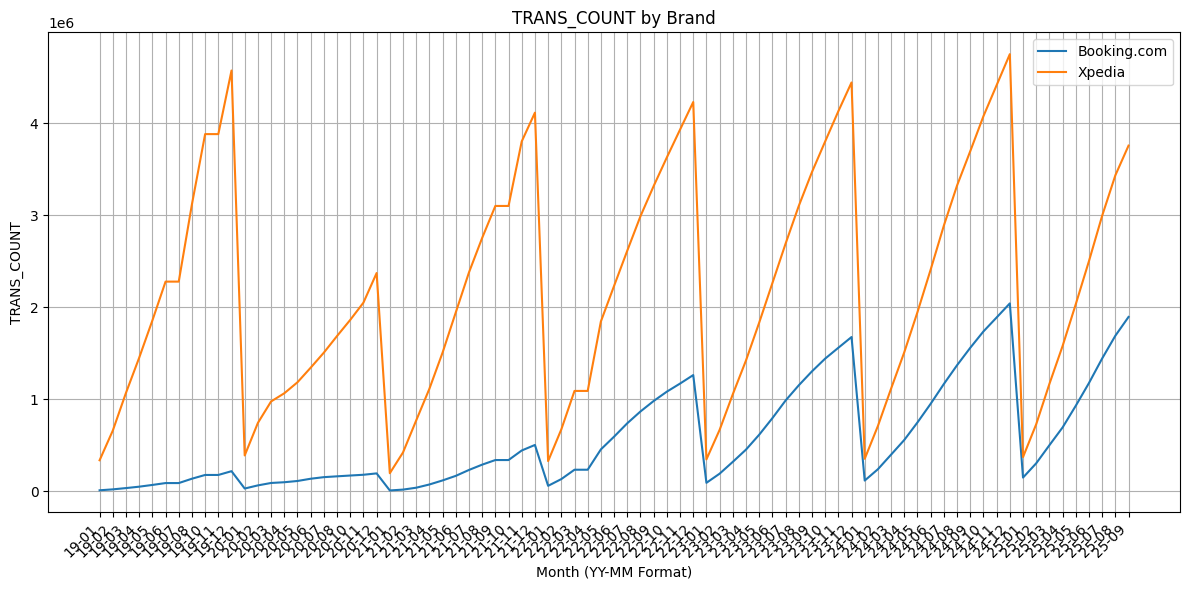

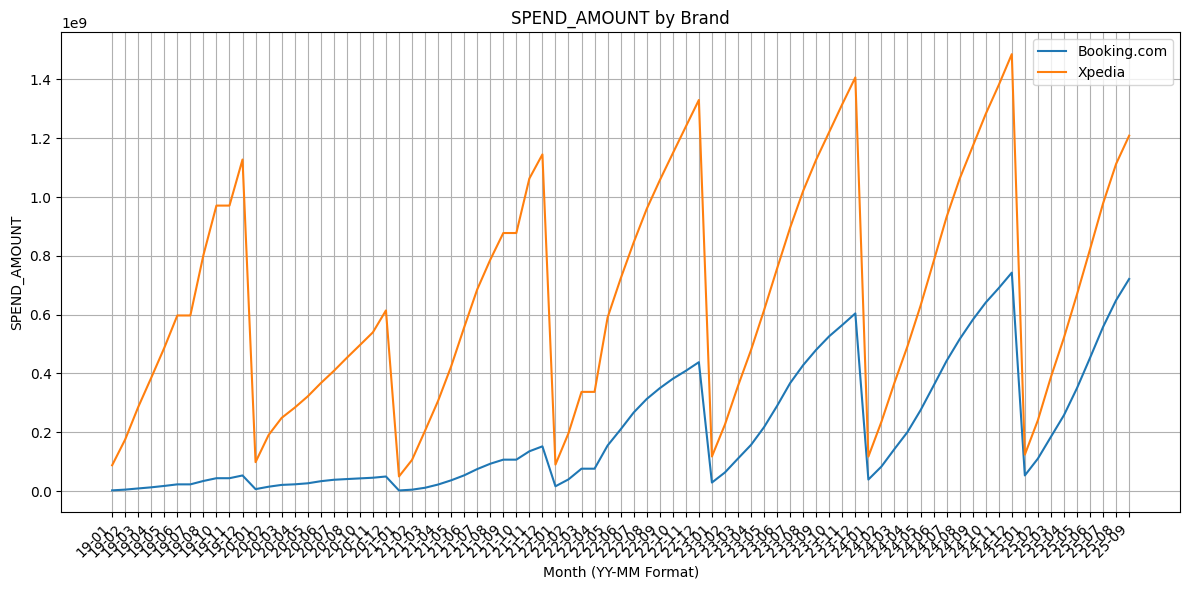

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("./data")

def load_all():
    files = sorted(DATA_DIR.glob("*.csv"))
    series_tc = {}
    series_sp = {}
    for f in files:
        brand = f.stem.strip().lower().capitalize()
        df = pd.read_csv(f)
        dt = pd.to_datetime(df["YYMM"].astype(str), format="%y%m")
        tc = pd.to_numeric(df["TRANS_COUNT"])
        sp = pd.to_numeric(df["SPEND_AMOUNT"])
        series_tc[brand] = pd.Series(tc.values, index=dt).sort_index()
        series_sp[brand] = pd.Series(sp.values, index=dt).sort_index()
    return series_tc, series_sp

def build_union_index(series_dict):
    idx = None
    for s in series_dict.values():
        idx = s.index if idx is None else idx.union(s.index)
    return idx.sort_values()

def make_axis(union_idx, ax, title, ylabel):
    x = np.arange(len(union_idx))
    ax.set_title(title)
    ax.set_xlabel("Month (YY-MM Format)")
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels([d.strftime("%y-%m") for d in union_idx], rotation=45, ha="right")
    return x

def plot_series(ax, xgrid, union_idx, series_dict):
    for brand, s in series_dict.items():
        y = s.reindex(union_idx).to_numpy()
        mask = ~np.isnan(y)
        ax.plot(xgrid[mask], y[mask], label=brand)
    ax.legend()
    ax.grid(True)

DATA_DIR.mkdir(parents=True, exist_ok=True)
series_tc, series_sp = load_all()

# Plot TRANS_COUNT
union_idx_tc = build_union_index(series_tc)
fig1, ax1 = plt.subplots(figsize=(12, 6))
x_tc = make_axis(union_idx_tc, ax1, "TRANS_COUNT by Brand", "TRANS_COUNT")
plot_series(ax1, x_tc, union_idx_tc, series_tc)
fig1.tight_layout()
fig1.savefig(DATA_DIR / "brand_trans_count.png", dpi=200, bbox_inches="tight")

# Plot SPEND_AMOUNT
union_idx_sp = build_union_index(series_sp)
fig2, ax2 = plt.subplots(figsize=(12, 6))
x_sp = make_axis(union_idx_sp, ax2, "SPEND_AMOUNT by Brand", "SPEND_AMOUNT")
plot_series(ax2, x_sp, union_idx_sp, series_sp)
fig2.tight_layout()
fig2.savefig(DATA_DIR / "brand_spend_amount.png", dpi=200, bbox_inches="tight")

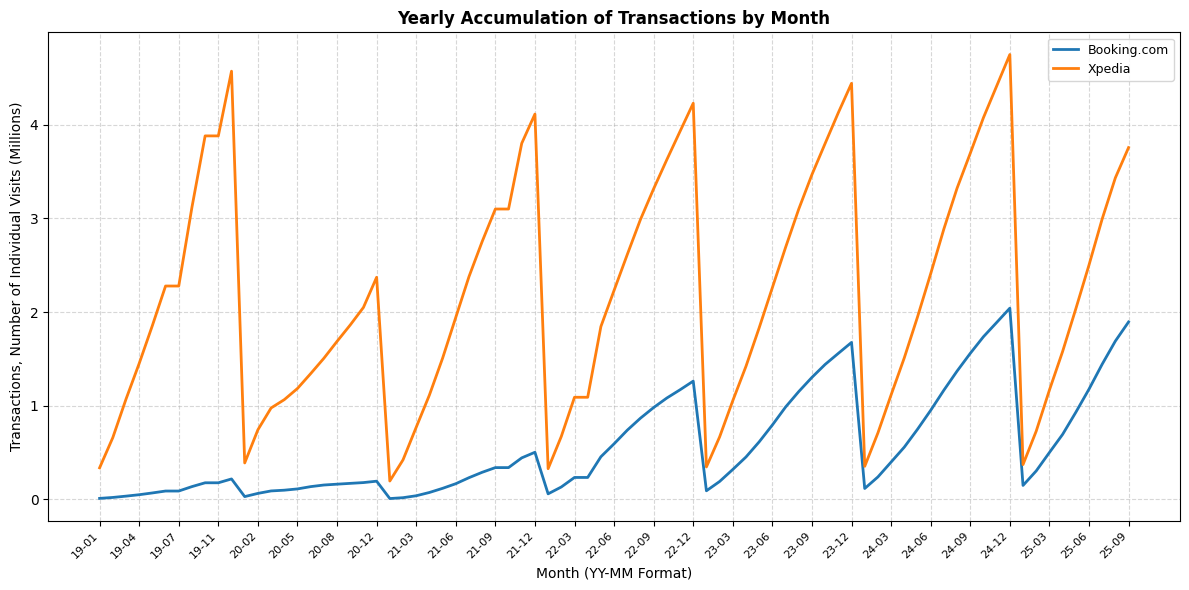

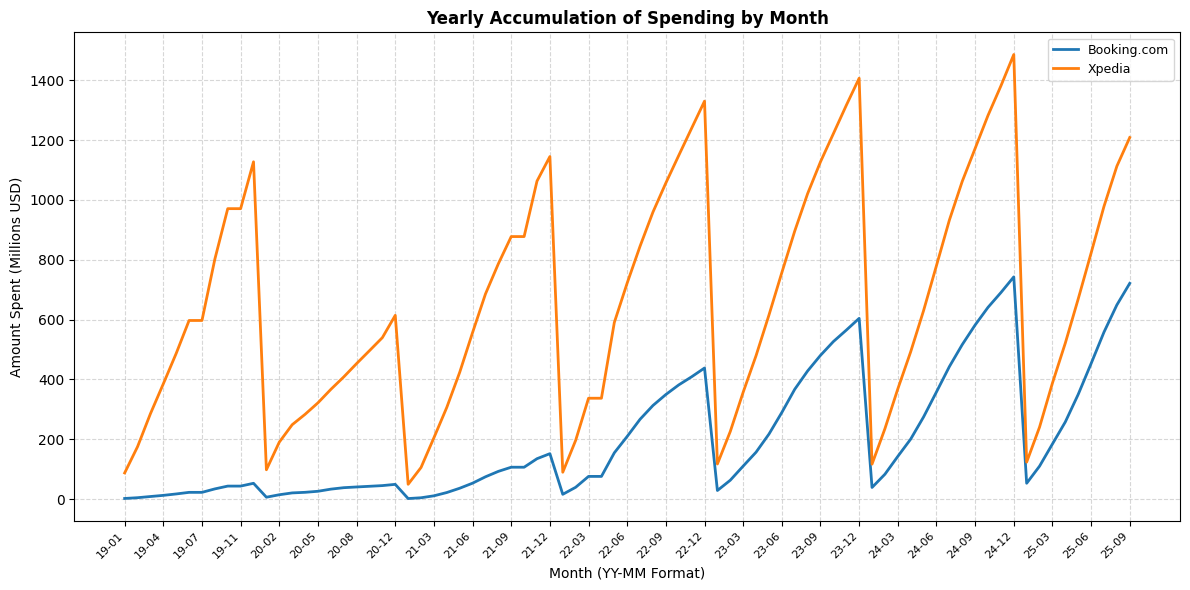

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("./data")

def load_all():
    files = sorted(DATA_DIR.glob("*.csv"))
    series_tc = {}
    series_sp = {}
    for f in files:
        brand = f.stem.strip().lower().capitalize()
        df = pd.read_csv(f)
        dt = pd.to_datetime(df["YYMM"].astype(str), format="%y%m")
        tc = pd.to_numeric(df["TRANS_COUNT"])
        sp = pd.to_numeric(df["SPEND_AMOUNT"])
        series_tc[brand] = pd.Series(tc.values, index=dt).sort_index()
        series_sp[brand] = pd.Series(sp.values, index=dt).sort_index()
    return series_tc, series_sp

def build_union_index(series_dict):
    idx = None
    for s in series_dict.values():
        idx = s.index if idx is None else idx.union(s.index)
    return idx.sort_values()

def make_axis(union_idx, ax, title, ylabel):
    x = np.arange(len(union_idx))
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Month (YY-MM Format)")
    ax.set_ylabel(ylabel)
    step = max(1, len(union_idx) // 24)
    tick_positions = x[::step]
    tick_labels = [d.strftime("%y-%m") for d in union_idx[::step]]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=8)
    return x

def plot_series(ax, xgrid, union_idx, series_dict):
    # Nike = dark blue, Adidas = black, Lululemon = pink
    color_map = {"Nike": "#0033A0", "Adidas": "black", "Lululemon": "hotpink"}
    for brand, s in series_dict.items():
        y = s.reindex(union_idx).to_numpy() / 1_000_000  # convert to millions
        mask = ~np.isnan(y)
        ax.plot(xgrid[mask], y[mask], label=brand, color=color_map.get(brand, None), linewidth=2)
    ax.legend(fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.5)

DATA_DIR.mkdir(parents=True, exist_ok=True)
series_tc, series_sp = load_all()

# Plot Transactions (Millions of Individual Visits)
union_idx_tc = build_union_index(series_tc)
fig1, ax1 = plt.subplots(figsize=(12, 6))
x_tc = make_axis(union_idx_tc, ax1,
    "Yearly Accumulation of Transactions by Month",
    "Transactions, Number of Individual Visits (Millions)"
)
plot_series(ax1, x_tc, union_idx_tc, series_tc)
fig1.tight_layout()
fig1.savefig(DATA_DIR / "brand_trans_count.png", dpi=200, bbox_inches="tight")

# Plot Spending (Millions USD)
union_idx_sp = build_union_index(series_sp)
fig2, ax2 = plt.subplots(figsize=(12, 6))
x_sp = make_axis(union_idx_sp, ax2,
    "Yearly Accumulation of Spending by Month",
    "Amount Spent (Millions USD)"
)
plot_series(ax2, x_sp, union_idx_sp, series_sp)
fig2.tight_layout()
fig2.savefig(DATA_DIR / "brand_spend_amount.png", dpi=200, bbox_inches="tight")
